# Numerical differentiation of noisy data: A unifying multi-objective optimization framework

This notebook builds on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) time step (note: we concentrated on differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the time series you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
import numpy as np
import os, sys
# local import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pynumdiff.optimize import optimize
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_cruise_control, lorenz_x
from pynumdiff.finite_difference import finite_difference
from pynumdiff.smooth_finite_difference import mediandiff, meandiff, gaussiandiff,\
    friedrichsdiff, butterdiff, splinediff
from pynumdiff.total_variation_regularization import tvrdiff, smooth_acceleration
from pynumdiff.linear_model import spectraldiff, polydiff, savgoldiff, lineardiff
from pynumdiff.kalman_smooth import rts_const_deriv

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_cruise_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.1]

# time step and time series length
dt = 0.01 # sampling time step
duration = 4 # sec
problem = pi_cruise_control

x, x_truth, dxdt_truth = problem(duration, 
                                noise_parameters=noise_parameters, 
                                dt=dt)

For our toy problems we can optimize the parameters in one of two options:
1. Use the known dxdt to find the best parameters 
2. Actual dxdt is unknown

In the real world, option (1) is not possible, so this notebook focuses on case (2). For the first case, see notebook 2a.

The optimization approach described here solves a loss function that balances the faithfulness and smoothness of the derivative estimate, and relies on a single hyperparameter, $\gamma$, or `tvgamma` in the code. See the paper for more detail, but a brief overview is given here.

The loss function to find the optimal parameters is as follows,

$$L = \text{RMSE} \bigg( \text{trapz}(\mathbf{\hat{\dot{x}}}(\Phi)) + \mu, \mathbf{y} \bigg) + \gamma \bigg({TV}\big(\mathbf{\hat{\dot{x}}}(\Phi)\big)\bigg),$$
where $\mathbf{y}$ are the noisy measurements, $\mathbf{\hat{\dot{x}}}$ is the estimate of the derivative, $\text{trapz}(\cdot)$ is the discrete-time trapezoidal numerical integral, $\mu$ resolves the unknown integration constant, $\gamma$ is a hyper-parameter, and $TV$ is the total variation,

$$TV(\mathbf{\hat{\dot{x}}}) = \frac{1}{m}\left\lVert\mathbf{\hat{\dot{x}}}_{0:m-1}-\mathbf{\hat{\dot{x}}}_{1:m}\right\rVert_{1}.$$

To use the code to  solve the loss function and find your optimal parameters is quite simple.

First, find tvgamma using the following heuristic: 

In [4]:
cutoff_frequency = 3 # high frequency of signal in the data. 
# estimate by (a) counting real # peaks per second in the data or (b) look at power spectrum and choose cutoff. 
log_gamma = -1.6*np.log(cutoff_frequency) -0.71*np.log(dt) - 5.1
tvgamma = np.exp(log_gamma)
print("tvgamma:", tvgamma)

tvgamma: 0.02765057294701546


Use the following syntax, as detailed in the notebook:

```python
from pynumdiff.optimize import optimize
from pynumdiff.module import method

search_space_updates = {'param1':[values], 'param2':[values], ...}

params, val = optimize(method, x, dt,
                    tvgamma=tvgamma, # hyperparameter
                    dxdt_truth=dxdt_truth, # defaults to None if no ground truth data
                    search_space_updates=search_space_updates)
   
x_hat, dxdt_hat = method(x, dt, **params)
```

where `param`s are keyword arguments that come from the method definition. If you don't know a search space, default search spaces are defined for all methods in `optimize.py`. Partial search spaces are accepted, simply replacing relevant entries in the default search space. Reasonable upper and lower bounds are defined for numerical search space dimensions (type `int` or `float`). Data type `bool` can also be searched over, but searching over `str` parameters is currently not supported.

## 1. Smooth Finite Difference

### 1.1 Smooth Finite Difference: Mean smoothing

Optimal parameters:  {'window_size': 5, 'num_iterations': 5}
RMS error in velocity:  0.6598729612725536
Error correlation:  0.15507991647618785


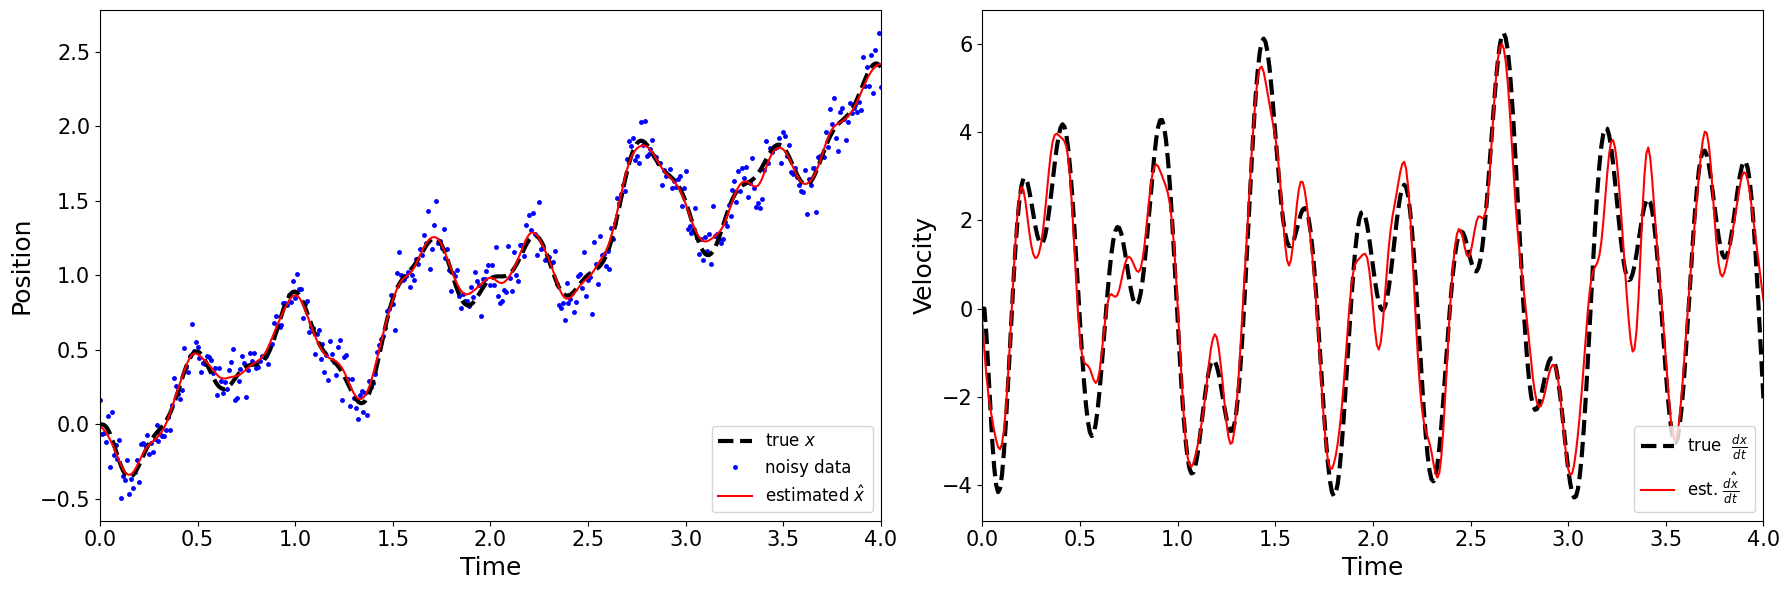

In [4]:
params, val = optimize(meandiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = meandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.2 Smooth Finite Difference: Median smoothing

Optimal parameters:  {'window_size': 12, 'num_iterations': 6}
RMS error in velocity:  1.7021719766834533
Error correlation:  0.06181794611701988


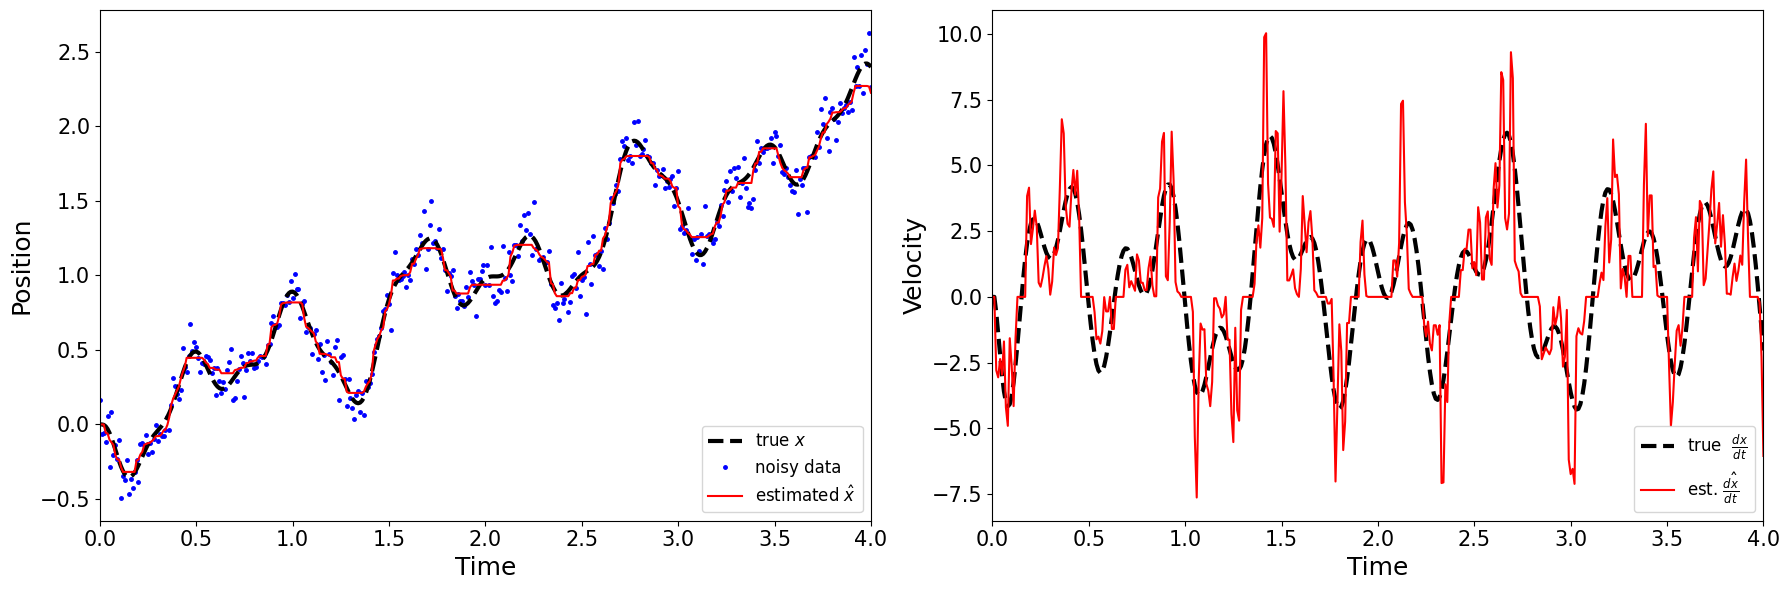

In [5]:
params, val = optimize(mediandiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = mediandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.3 Smooth Finite Difference: Gaussian smoothing

Optimal parameters:  {'window_size': 15, 'num_iterations': 1}
RMS error in velocity:  0.8290243211040939
Error correlation:  0.031322912104586


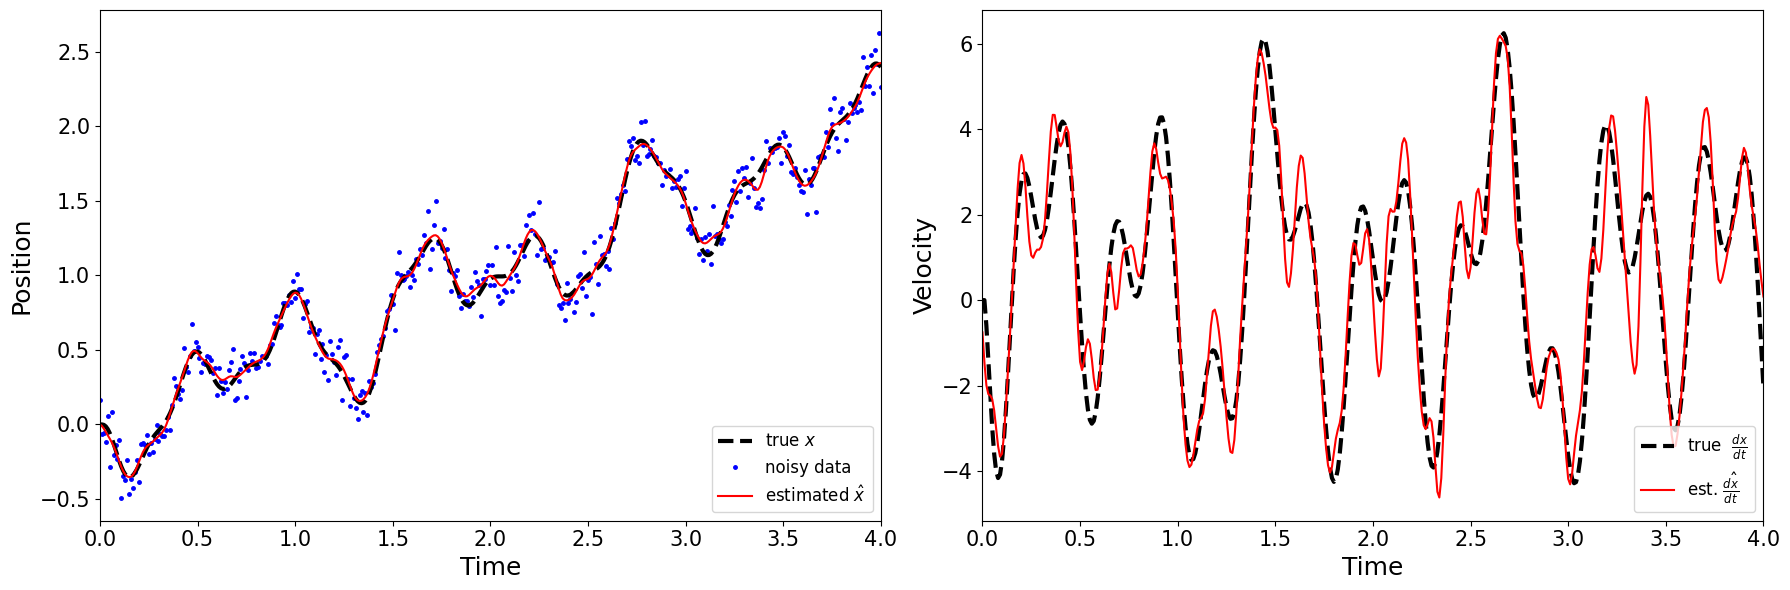

In [6]:
params, val = optimize(gaussiandiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = gaussiandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.4 Smooth Finite Difference: Friedrichs smoothing

Optimal parameters:  {'window_size': 5, 'num_iterations': 10}
RMS error in velocity:  0.884089053803316
Error correlation:  0.020396849396969754


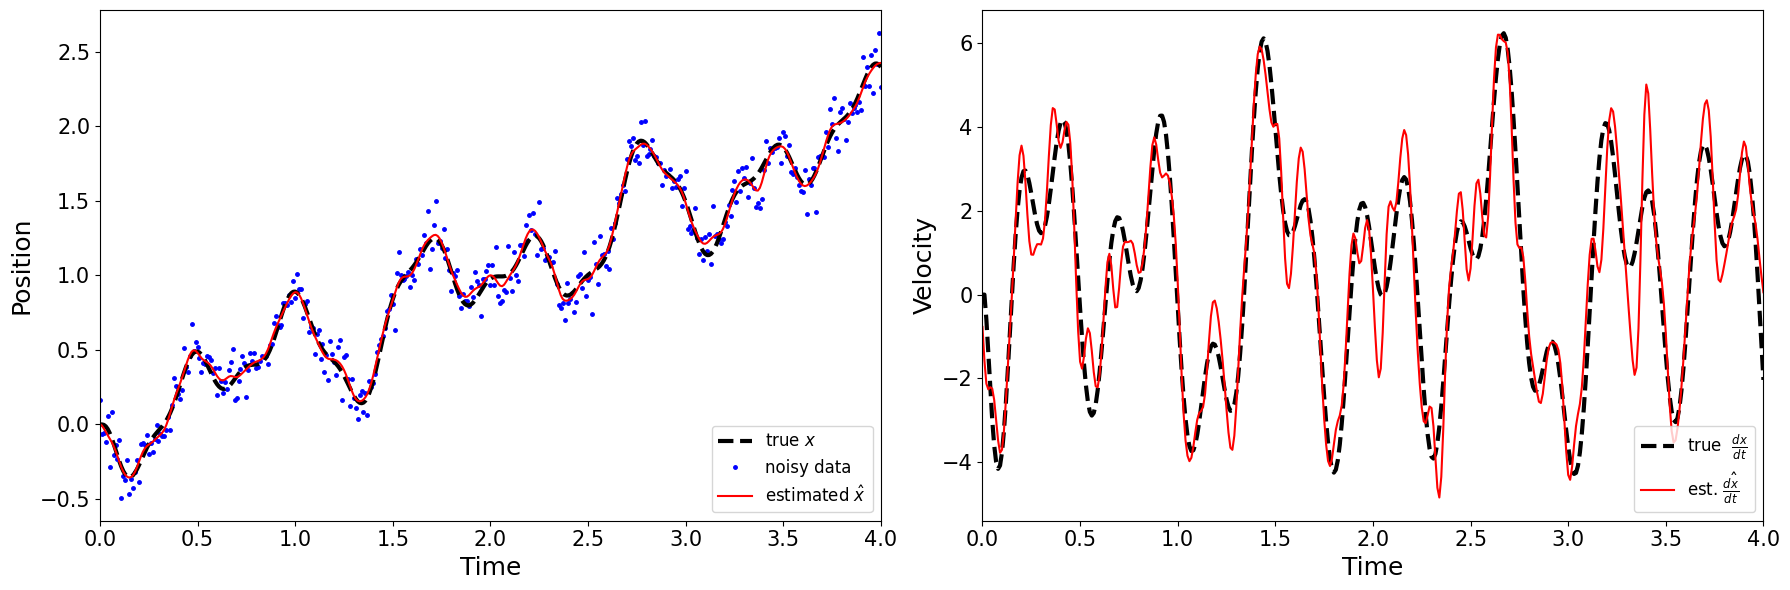

In [7]:
params, val = optimize(friedrichsdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = friedrichsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.5 Smooth Finite Difference: Butterworth smoothing

Optimal parameters:  {'cutoff_freq': np.float64(0.13000000000000012), 'num_iterations': 1, 'filter_order': 2}
RMS error in velocity:  0.9222706061676474
Error correlation:  3.606616801556012e-06


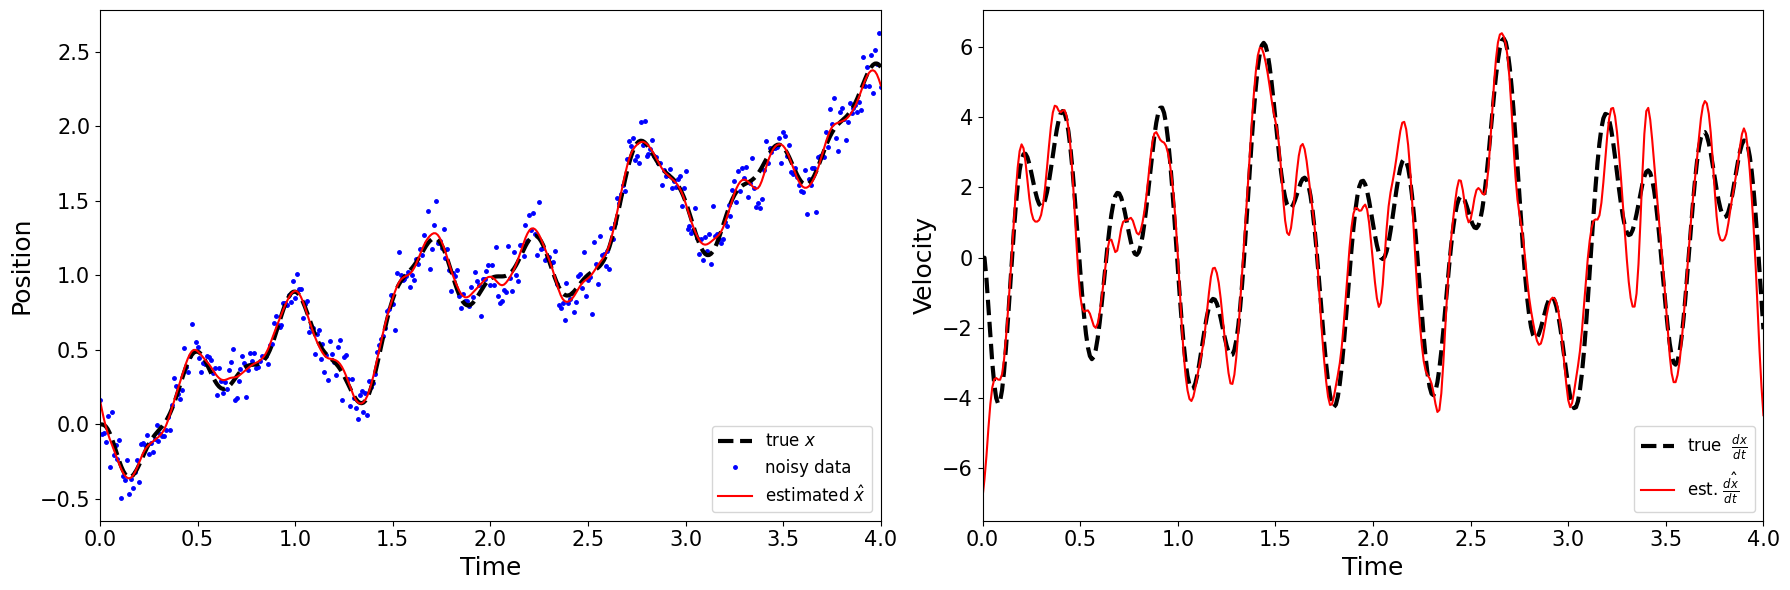

In [8]:
params, val = optimize(butterdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 2. Polynomial-Based Methods

### 2.1 Spline smoothing

Optimal parameters:  {'s': np.float64(0.5531249999999999), 'num_iterations': 5, 'order': 3}
RMS error in velocity:  0.5978465256219235
Error correlation:  0.009683164447145755


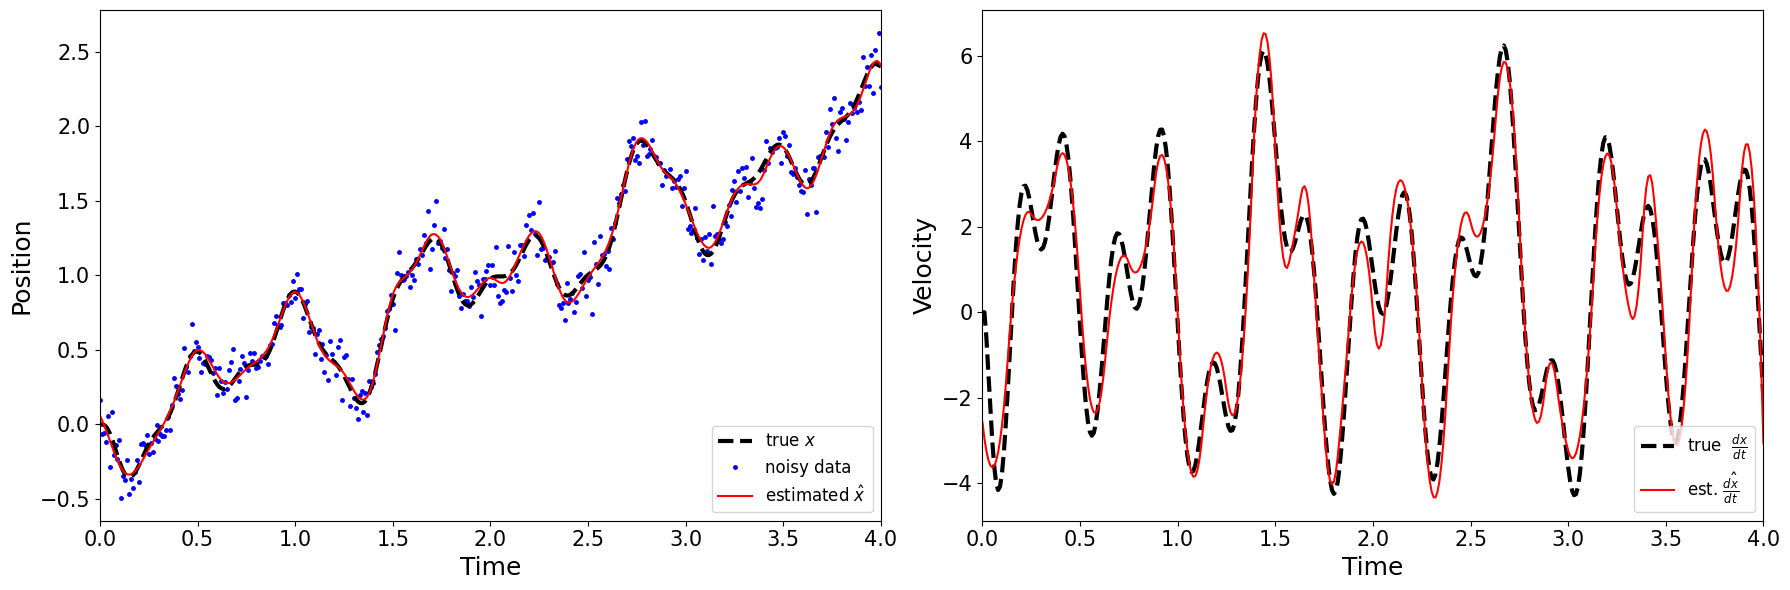

In [9]:
params, val = optimize(splinediff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Sliding Polynomial Fit

Optimal parameters:  {'step_size': 1, 'poly_order': 2, 'window_size': 27, 'kernel': 'gaussian'}
RMS error in velocity:  0.6590705824066536
Error correlation:  1.9556342504970285e-05


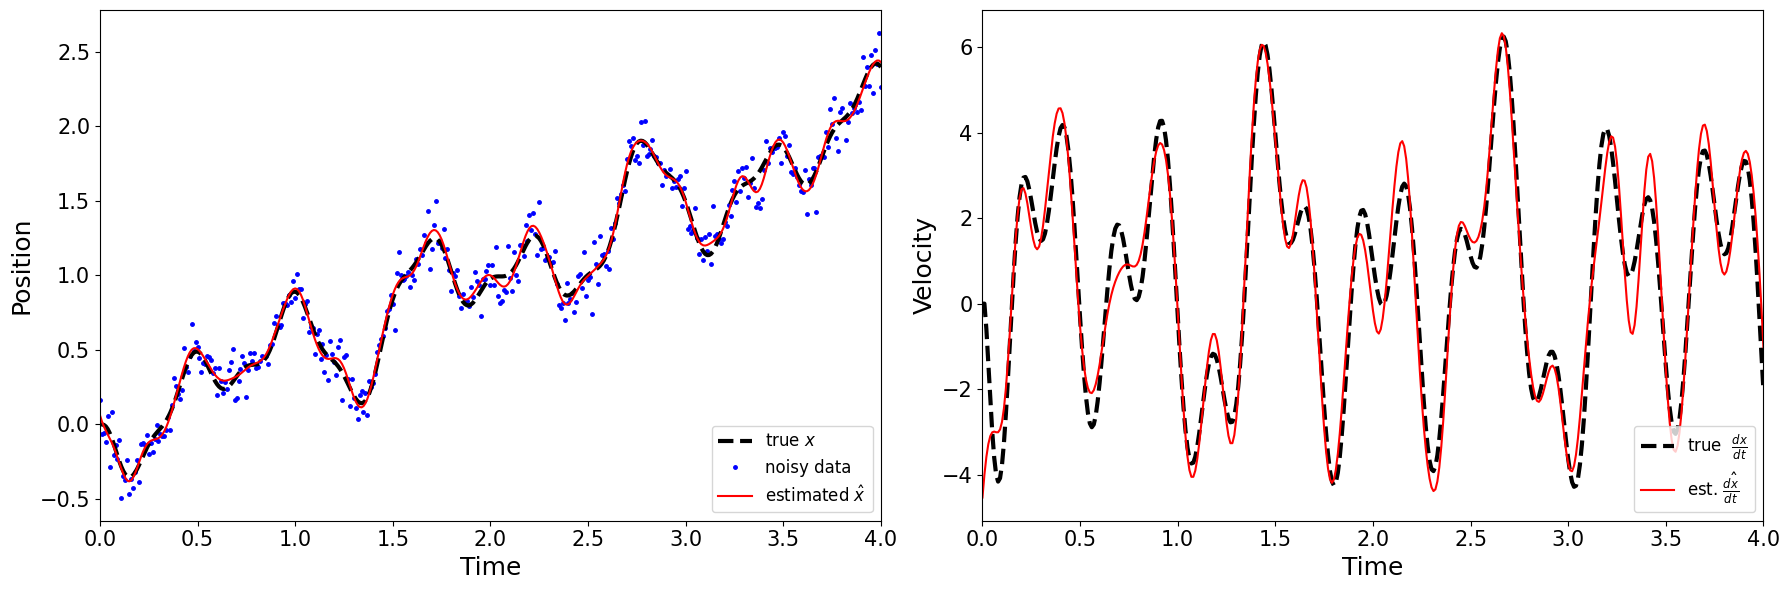

In [10]:
params, val = optimize(polydiff, x, dt, tvgamma=tvgamma, search_space_updates={'step_size':[1, 2, 5]})
print('Optimal parameters: ', params)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Savitzky-Golay Filter

Optimal parameters:  {'poly_order': 3, 'window_size': 21, 'smoothing_win': 11}
RMS error in velocity:  0.6735648325578836
Error correlation:  0.013784684383151752


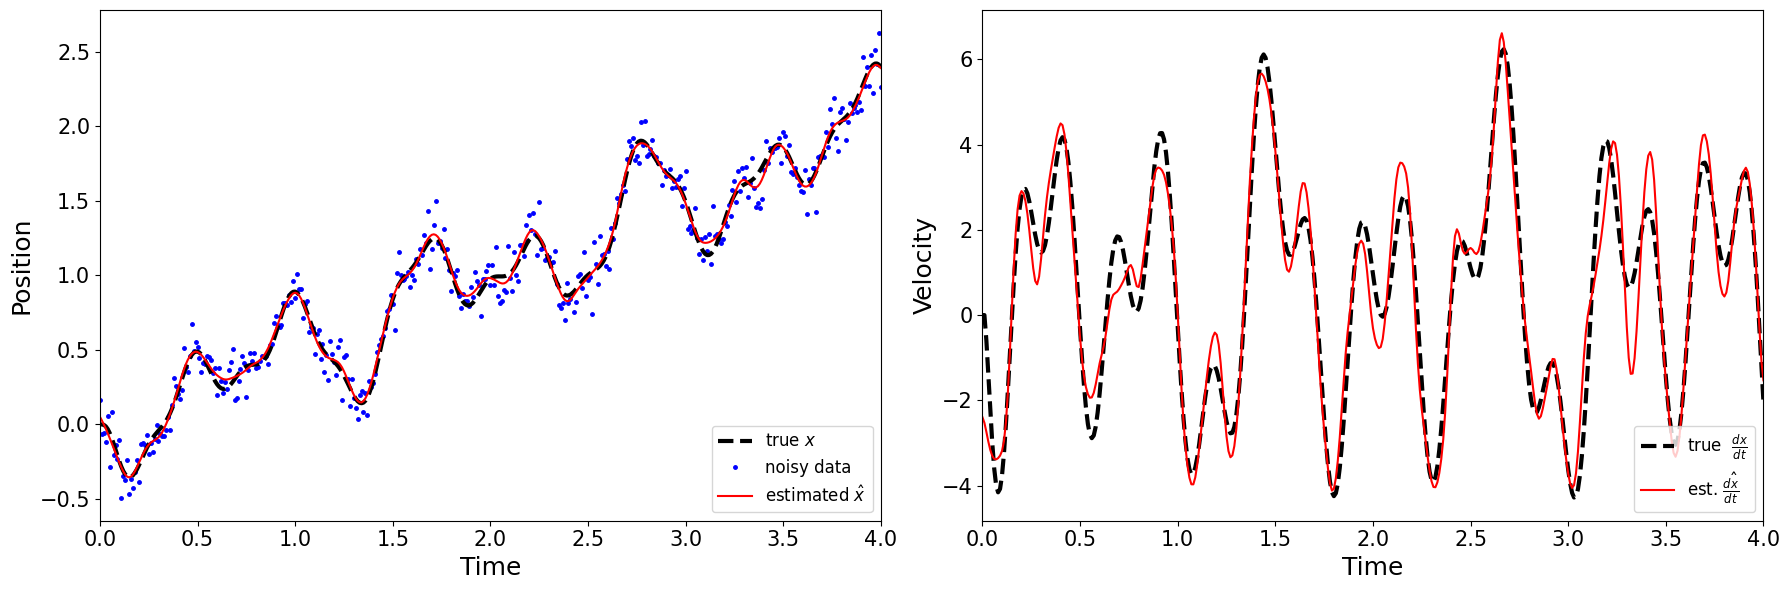

In [11]:
params, val = optimize(savgoldiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 3. Iterated Finite Difference

Optimal parameters:  {'num_iterations': 44, 'order': 4}
RMS error in velocity:  0.8003648466195363
Error correlation:  0.03928755219748744


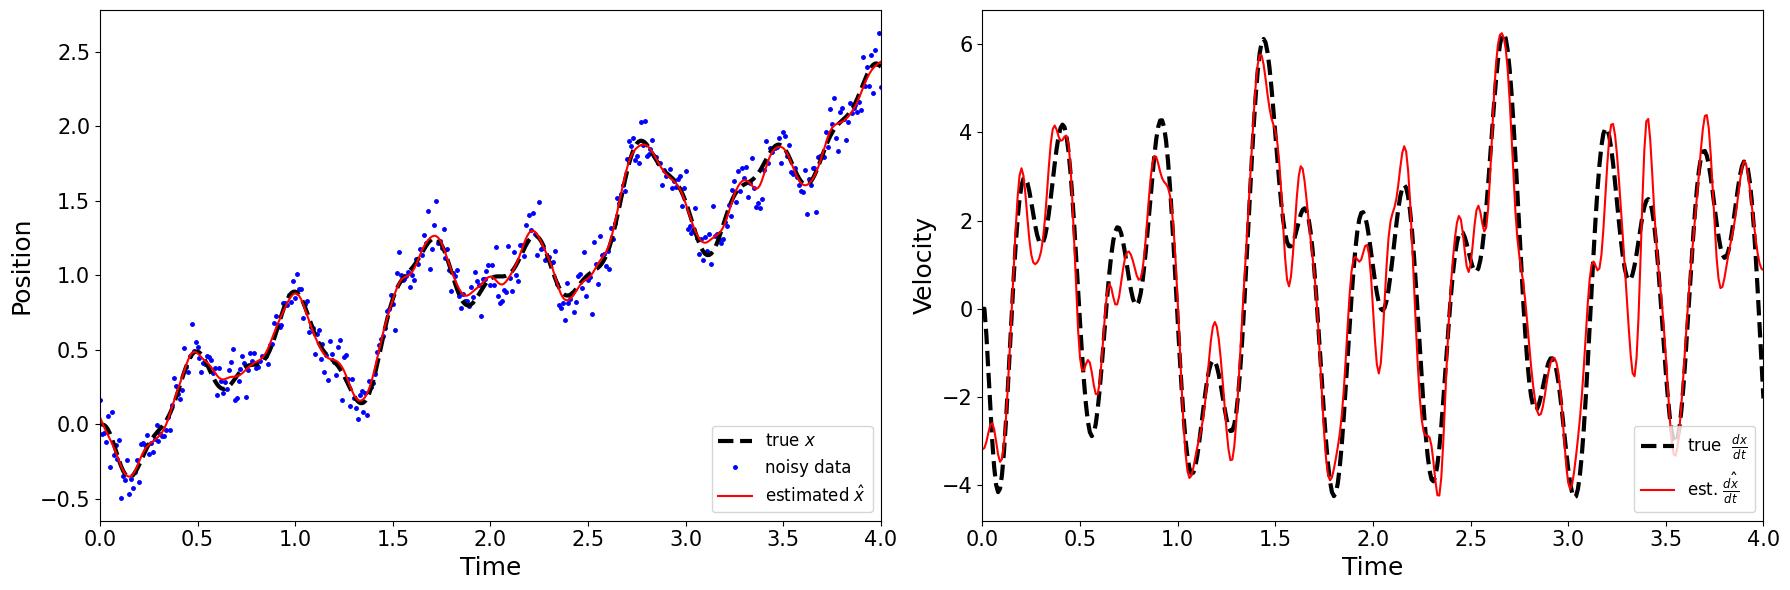

In [12]:
params, val = optimize(finite_difference, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = finite_difference(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 4. Total Variation Regularization

### 4.1 Convex TVRed Derivative

Optimal parameters:  {'gamma': np.float64(3.9350000000000143), 'order': 3}
RMS error in velocity:  0.7573847997575724
Error correlation:  0.0061836943308965775


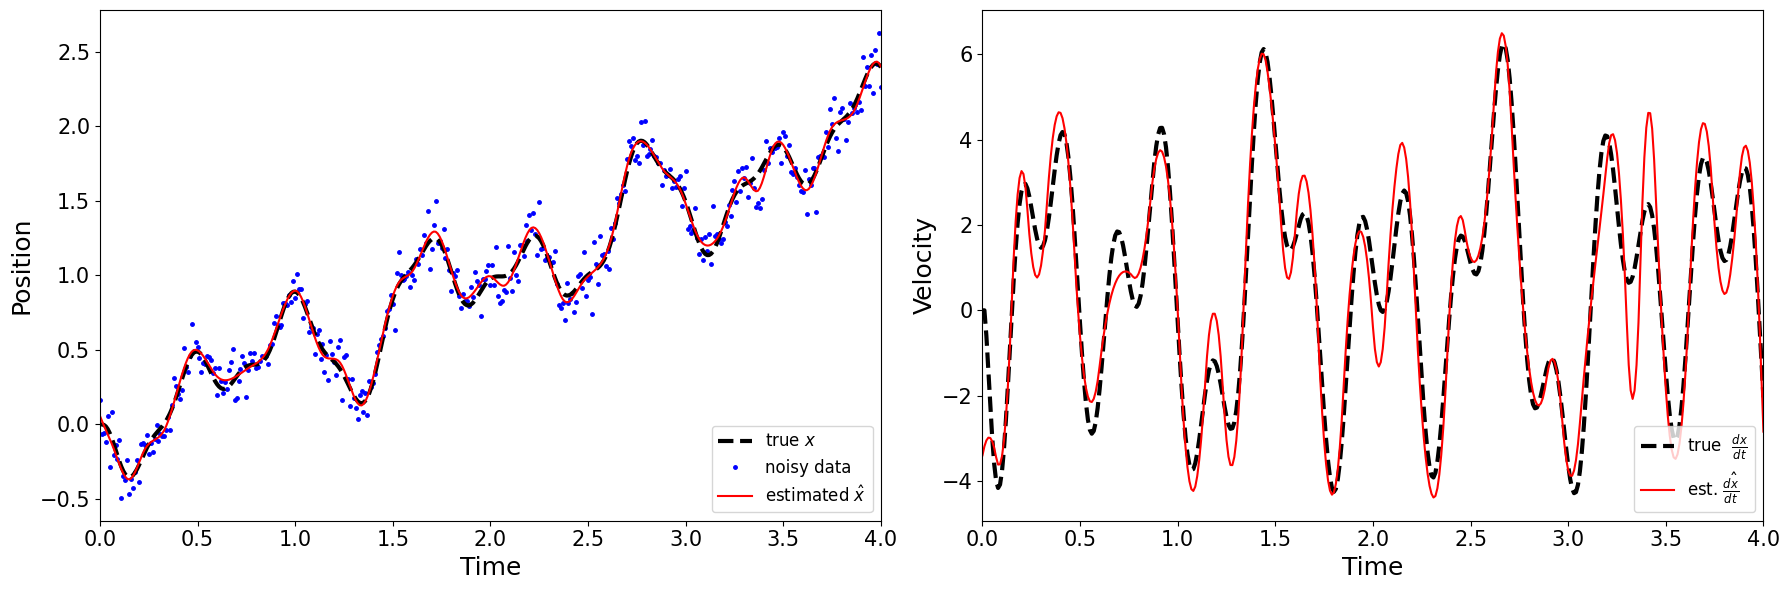

In [6]:
params, val = optimize(tvrdiff, x, dt, tvgamma=tvgamma, search_space_updates={'order':{2,3}})
print('Optimal parameters: ', params)
x_hat, dxdt_hat = tvrdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

Optimal parameters:  {'gamma': np.float64(1.0578125000000003), 'window_size': 9}
RMS error in velocity:  0.7918686221780956
Error correlation:  0.0010849208847496397


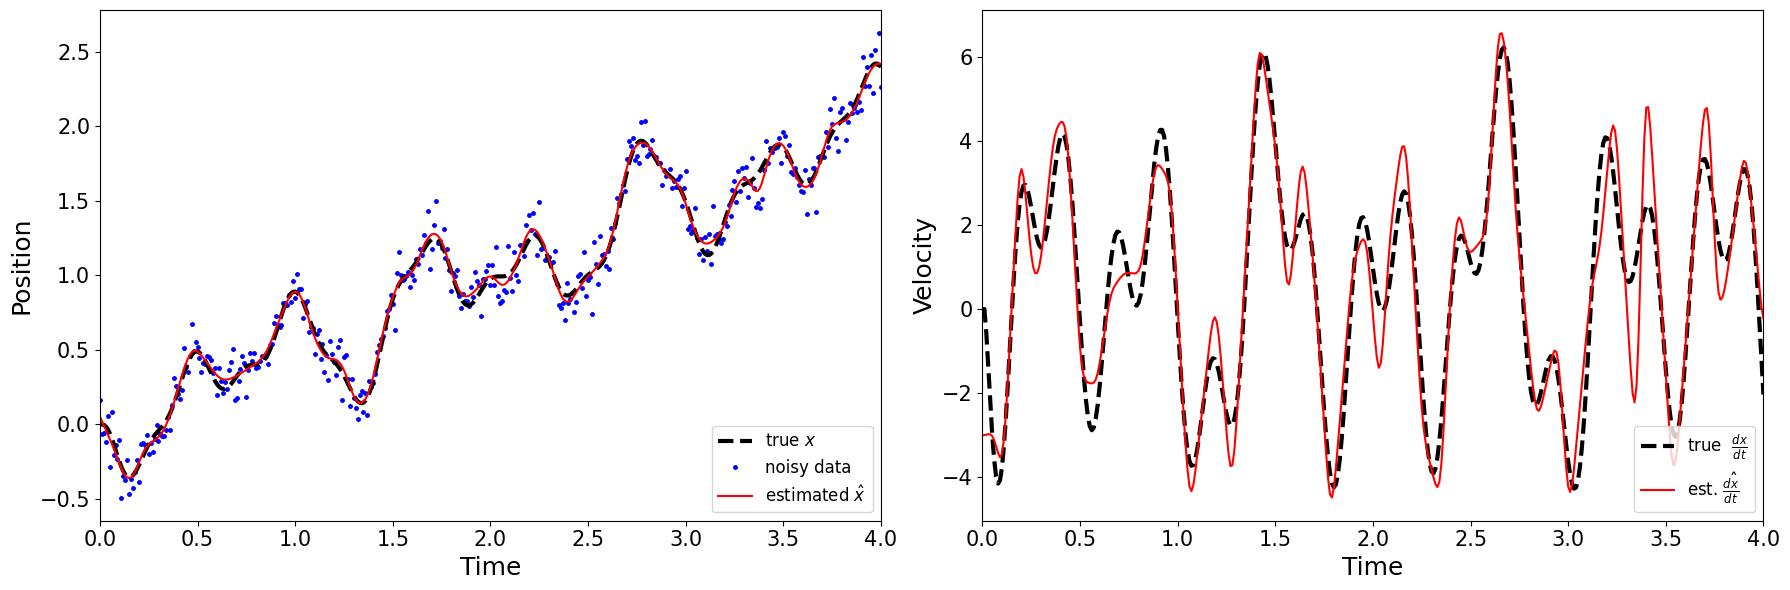

In [14]:
params, val = optimize(smooth_acceleration, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 5. Kalman smoothing

a.k.a. RTS smoothing

Optimal parameters:  {'qr_ratio': np.float64(212.5), 'forwardbackward': True, 'order': 1}
RMS error in velocity:  0.732788003100273
Error correlation:  0.0087737054466213


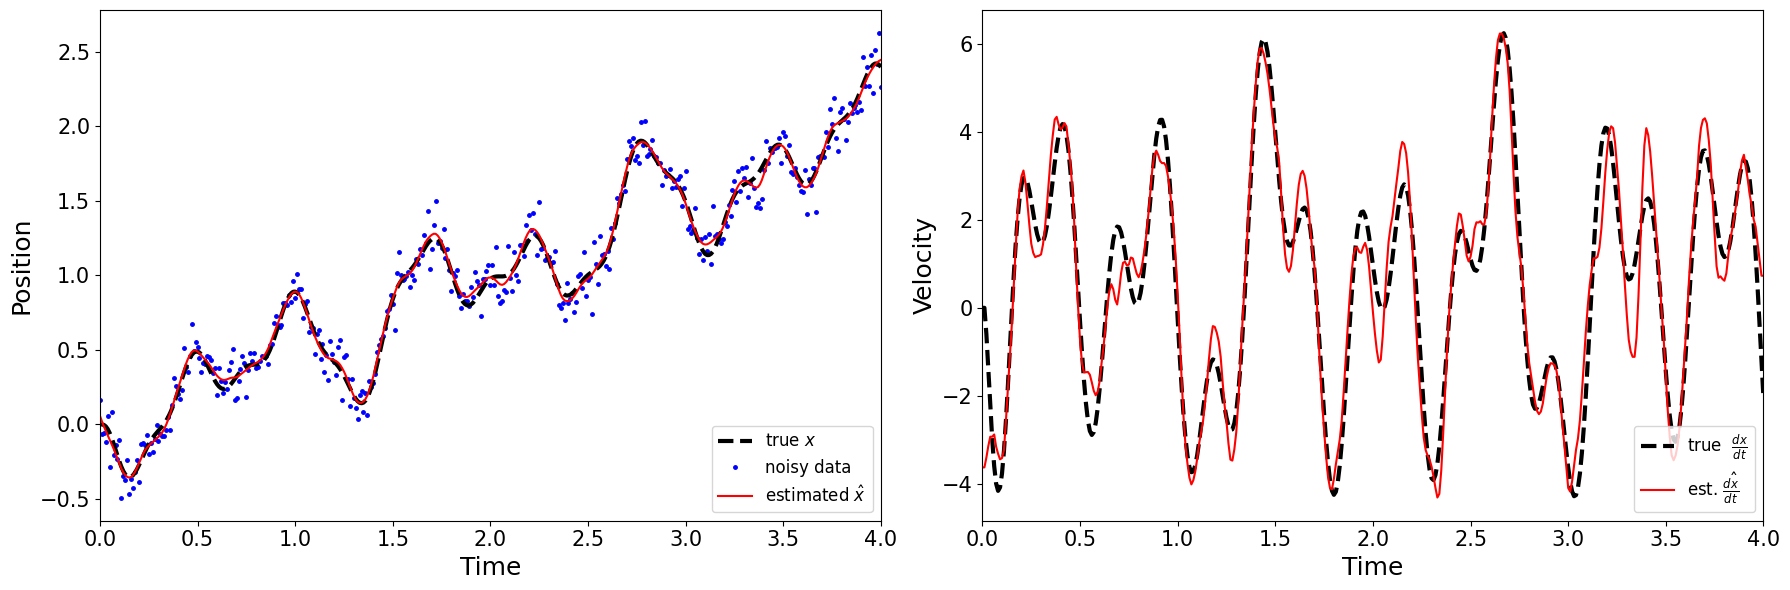

In [15]:
params, val = optimize(rts_const_deriv, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = rts_const_deriv(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 6. Spectral Derivative with Tricks

Optimal parameters:  {'high_freq_cutoff': np.float64(0.12500000000000008), 'even_extension': True, 'pad_to_zero_dxdt': False}
RMS error in velocity:  0.7557838482515354
Error correlation:  0.015865742218535737


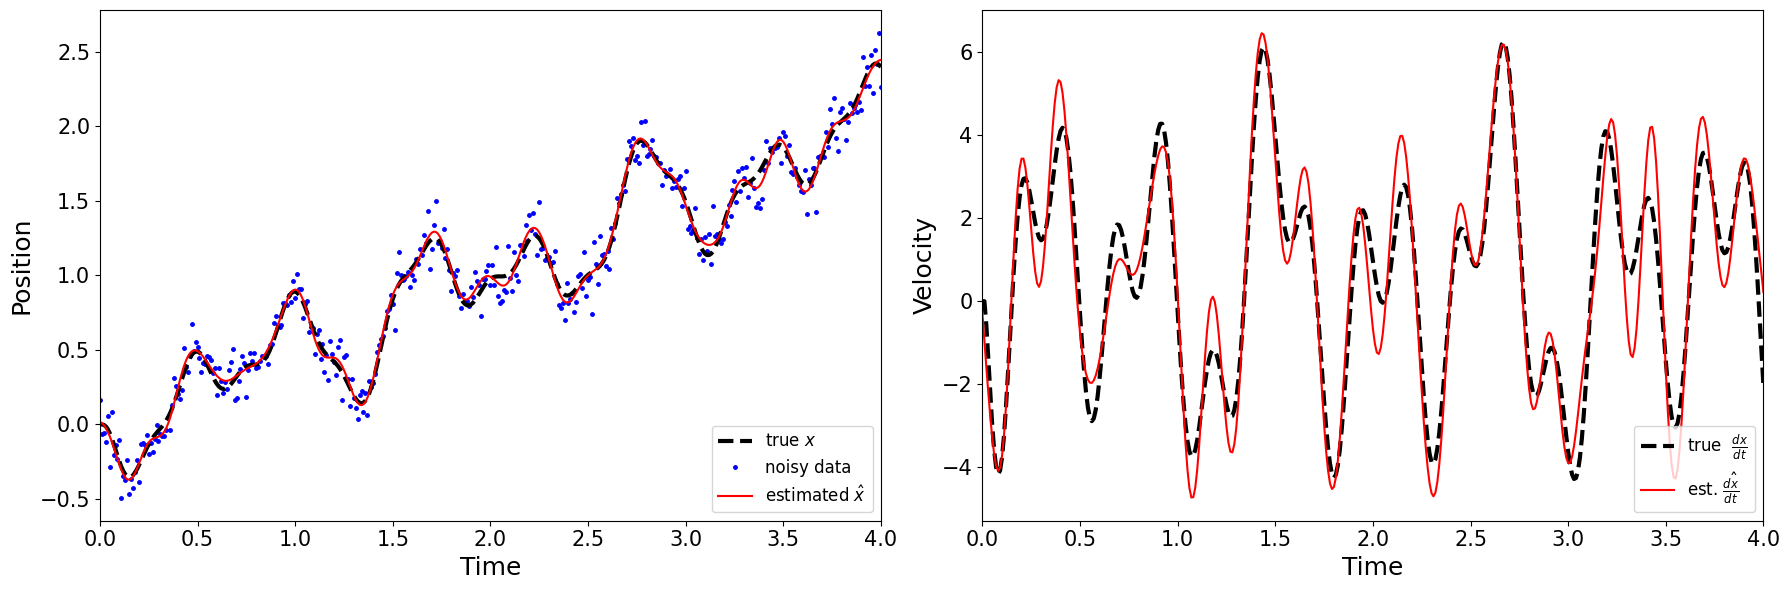

In [16]:
params, val = optimize(spectraldiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 7. Linear Model: Sliding linear time invariant system fit

In [17]:
if 0: # this one is too slow and runtime error prone!
    params, val = optimize(lineardiff, x, dt, tvgamma=tvgamma)
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = lineardiff(x, dt, **params)
    evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)